In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import itertools

# Preprocess

In [2]:
date_times = [
    "Date", "Booking Date",
    "Actual Room In DateTime",
    "Actual Room Out DateTime"
]
data = pd.read_excel("../Data/UVM_OR_DATA.xlsx", parse_dates=date_times)

var_list = [
    "Case", "Date", "Booking Date", "Room", "Primary Department",
    "Patient Type", "Elective", "Actual Room In DateTime",
    "Actual Room Out DateTime"
]
data = data[var_list]

data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" ", "_")

# extract surgery date, month and weekend indicator
data["Surgery_Date"] = pd.to_datetime(data["Actual_Room_In_DateTime"].dt.date)
data["Actual_Month"] = data['Surgery_Date'].dt.strftime('%b')
data["Weekend"] = data['Surgery_Date'].dt.strftime('%a')
data["Weekend"] = np.where(
    data["Weekend"].isna(), np.nan,
    np.where(
        data["Weekend"].isin(["Sat", "Sun"]), 1, 0
    )
)

policy_date = pd.to_datetime("May 1, 2019")

# Block times at UVMMC are 07:00-17:00 Monday, Tuesday, Wednesday and Friday.  Thursday 08:00-17:00
data["StartTime"] = data["Surgery_Date"] + pd.to_timedelta("7 hours")
data["EndTime"] = data["Surgery_Date"] + pd.to_timedelta("17 hours")
data["OverUtilization_1"] = data["StartTime"] - data["Actual_Room_In_DateTime"]
data["OverUtilization_1"] = [x.days*24+x.seconds/3600 for x in data["OverUtilization_1"]]
data["OverUtilization_1"] = data["OverUtilization_1"].where(data["OverUtilization_1"]>0, 0)
data["OverUtilization_2"] = data["Actual_Room_Out_DateTime"] - data["EndTime"]
data["OverUtilization_2"] = [x.days*24+x.seconds/3600 for x in data["OverUtilization_2"]]
data["OverUtilization_2"] = data["OverUtilization_2"].where(data["OverUtilization_2"]>0, 0)
data["OverUtilization"] = data["OverUtilization_1"] + data["OverUtilization_2"]
data.drop(["StartTime", "EndTime", "OverUtilization_1", "OverUtilization_2"], axis=1, inplace=True)

compared_month = ["May", "Jun", "Jul", "Aug", "Sep", "Oct"]

# assign treatment and control group, pre- and post-intervention period
# release_0 = ["Acute Care Service", "Ortho Trauma", "Cardiothoracic"]
# release_72 = ["Ortho Hand"]
nonadopter = ["Acute Care Service", "Ortho Trauma", "Cardiothoracic", "Ortho Hand"]
data["Intervention"] = np.where(
    data["Primary_Department"].isna(), np.nan,
    np.where(
        data["Primary_Department"].isin(nonadopter), 0, 1
    )
)
data["Period"] = np.where(data["Booking_Date"]>= policy_date, 1, 0)

room_before = data[data["Surgery_Date"]<policy_date]["Room"].unique()
room_after = data[data["Surgery_Date"]>=policy_date]["Room"].unique()
rooms = set(room_after).intersection(room_before)

In [3]:
# aggregate daily utilization of each room
daily_room_utilization = data.groupby(
    ["Surgery_Date", "Room"],
    as_index=False
)[["OverUtilization"]].sum()

daily_room_utilization_treat = data[data["Intervention"]==1].groupby(
    ["Surgery_Date", "Room"],
    as_index=False
)[["OverUtilization"]].sum()

daily_room_utilization_control = data[data["Intervention"]==0].groupby(
    ["Surgery_Date", "Room"],
    as_index=False
)[["OverUtilization"]].sum()

In [4]:
panel_date_1 = pd.date_range(start="2018-08-01",
                             end="2018-10-31")
panel_date_2 = pd.date_range(start="2019-08-01",
                             end="2019-10-31")
panel_date_1 = panel_date_1.to_frame(index=False)
panel_date_2 = panel_date_2.to_frame(index=False)
panel_date_3m = pd.concat([panel_date_1, panel_date_2])
panel_date_3m = panel_date_3m.values[:, 0]

room_date_pair_3m = []
for pair in itertools.product(rooms, panel_date_3m):
    room_date_pair_3m.append(pair)
room_date_pair_3m = pd.DataFrame(room_date_pair_3m, columns=["Room", "Surgery_Date"])

In [5]:
panel_date_1 = pd.date_range(start="2018-07-01",
                             end="2018-10-31")
panel_date_2 = pd.date_range(start="2019-07-01",
                             end="2019-10-31")
panel_date_1 = panel_date_1.to_frame(index=False)
panel_date_2 = panel_date_2.to_frame(index=False)
panel_date_4m = pd.concat([panel_date_1, panel_date_2])
panel_date_4m = panel_date_4m.values[:, 0]

room_date_pair_4m = []
for pair in itertools.product(rooms, panel_date_4m):
    room_date_pair_4m.append(pair)
room_date_pair_4m = pd.DataFrame(room_date_pair_4m, columns=["Room", "Surgery_Date"])

In [6]:
daily_utilization_panel_treat_3m = pd.merge(
    room_date_pair_3m,
    daily_room_utilization_treat,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_treat_3m.fillna(0, inplace=True)

daily_utilization_panel_treat_3m['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_treat_3m["Surgery_Date"]]
daily_utilization_panel_treat_3m['Weekend'] = np.where(daily_utilization_panel_treat_3m['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_treat_3m['Month'] = [x.strftime("%b") for x in daily_utilization_panel_treat_3m["Surgery_Date"]]
daily_utilization_panel_treat_3m["Period"] = np.where(daily_utilization_panel_treat_3m["Surgery_Date"]>=policy_date, 1, 0)

daily_utilization_panel_control_3m = pd.merge(room_date_pair_3m,
                                              daily_room_utilization_control,
                                              on=["Room", "Surgery_Date"],
                                              how='left')
daily_utilization_panel_control_3m.fillna(0, inplace=True)

daily_utilization_panel_control_3m['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_control_3m["Surgery_Date"]]
daily_utilization_panel_control_3m['Weekend'] = np.where(daily_utilization_panel_control_3m['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_control_3m['Month'] = [x.strftime("%b") for x in daily_utilization_panel_control_3m["Surgery_Date"]]
daily_utilization_panel_control_3m["Period"] = np.where(daily_utilization_panel_control_3m["Surgery_Date"]>=policy_date, 1, 0)

In [7]:
daily_utilization_panel_treat_4m = pd.merge(
    room_date_pair_4m,
    daily_room_utilization_treat,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_treat_4m.fillna(0, inplace=True)

daily_utilization_panel_treat_4m['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_treat_4m["Surgery_Date"]]
daily_utilization_panel_treat_4m['Weekend'] = np.where(daily_utilization_panel_treat_4m['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_treat_4m['Month'] = [x.strftime("%b") for x in daily_utilization_panel_treat_4m["Surgery_Date"]]
daily_utilization_panel_treat_4m["Period"] = np.where(daily_utilization_panel_treat_4m["Surgery_Date"]>=policy_date, 1, 0)

daily_utilization_panel_control_4m = pd.merge(room_date_pair_4m,
                                              daily_room_utilization_control,
                                              on=["Room", "Surgery_Date"],
                                              how='left')
daily_utilization_panel_control_4m.fillna(0, inplace=True)

daily_utilization_panel_control_4m['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_control_4m["Surgery_Date"]]
daily_utilization_panel_control_4m['Weekend'] = np.where(daily_utilization_panel_control_4m['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_control_4m['Month'] = [x.strftime("%b") for x in daily_utilization_panel_control_4m["Surgery_Date"]]
daily_utilization_panel_control_4m["Period"] = np.where(daily_utilization_panel_control_4m["Surgery_Date"]>=policy_date, 1, 0)

# Parallel Trend

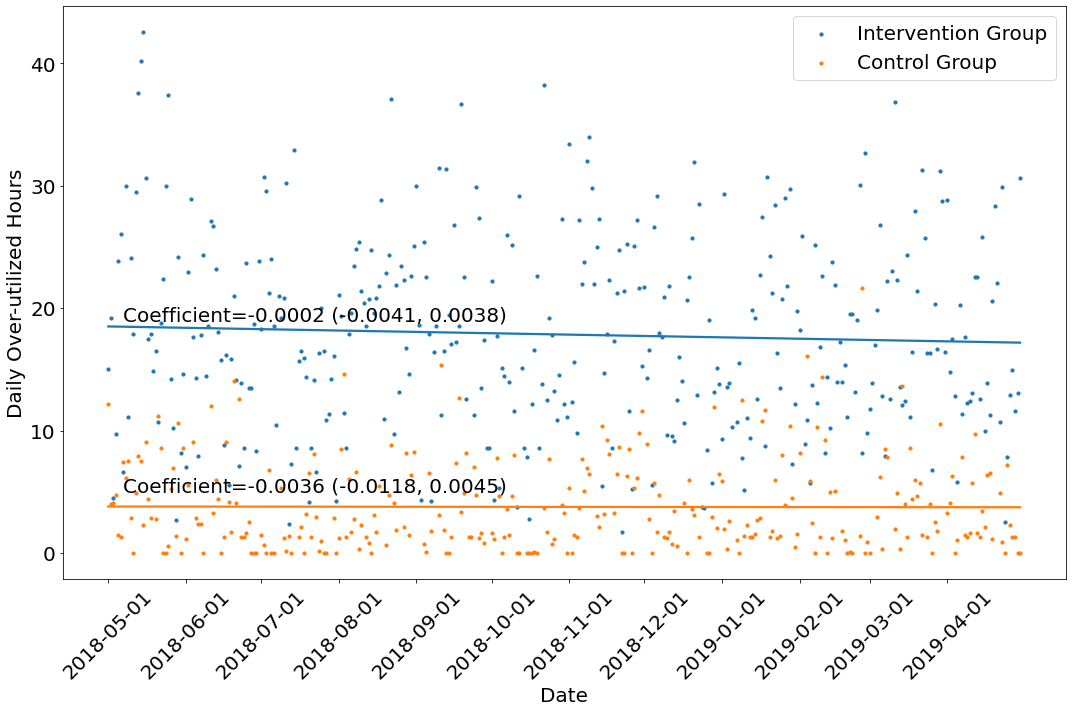

In [8]:
date_upper_limit = pd.to_datetime("2019-05-01")
date_lower_limit = pd.to_datetime("2018-05-01")

xticklabels = pd.date_range(date_lower_limit, date_upper_limit,
                            freq="MS", inclusive="left")
xticks = [x.days for x in xticklabels-date_lower_limit]
xticklabels = [x.date() for x in xticklabels]

parallel_data = data[
    (data["Surgery_Date"]<date_upper_limit) &
    (data["Surgery_Date"]>=date_lower_limit)
].groupby(["Surgery_Date", "Intervention"], as_index=False)[["OverUtilization"]].sum()

parallel_data['Weekend'] = [x.strftime("%a") for x in parallel_data["Surgery_Date"]]
parallel_data['Weekend'] = np.where(parallel_data['Weekend'].isin(["Sat", "Sun"]), 1, 0)
parallel_data["OverUtilization"] = (1-parallel_data['Weekend'])*parallel_data["OverUtilization"] + parallel_data['Weekend']*parallel_data["OverUtilization"]
parallel_data["x_date"] = [x.days for x in parallel_data["Surgery_Date"]-date_lower_limit]

model1 = sm.OLS(
    parallel_data[parallel_data["Intervention"]==0]["OverUtilization"],
    sm.add_constant(parallel_data[parallel_data["Intervention"]==0][["x_date", "Weekend"]])
)
result1 = model1.fit(cov_type="HC1")
theta1 = result1.params

model2 = sm.OLS(
    parallel_data[parallel_data["Intervention"]==1]["OverUtilization"],
    sm.add_constant(parallel_data[parallel_data["Intervention"]==1][["x_date", "Weekend"]])
)
result2 = model2.fit(cov_type="HC1")
theta2 = result2.params

parallel_data["OverUtilization"] = parallel_data["OverUtilization"] - parallel_data["Weekend"]*(theta1[2]*(1-parallel_data["Intervention"]) + theta2[2]*parallel_data["Intervention"])

plt.figure(figsize=(15, 10))
ax = plt.axes()

sns.regplot(
    x="x_date",
    y="OverUtilization",
    x_estimator=np.mean,
    data=parallel_data[parallel_data["Intervention"]==1],
    scatter_kws={"s": 10},
    ci=None,
    label="Intervention Group"
)

sns.regplot(
    x="x_date",
    y="OverUtilization",
    x_estimator=np.mean,
    data=parallel_data[parallel_data["Intervention"]==0],
    scatter_kws={"s": 10},
    ci=None,
    label="Control Group"
)

plt.text(6, 19, 
         "Coefficient=%.4f (%.4f, %.4f)" %(theta1[1], result1.conf_int().loc["x_date", 0], result1.conf_int().loc["x_date", 1]),
         fontsize=20)
plt.text(6, 5, 
         "Coefficient=%.4f (%.4f, %.4f)" %(theta2[1], result2.conf_int().loc["x_date", 0], result2.conf_int().loc["x_date", 1]), 
         fontsize=20)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Daily Over-utilized Hours", fontsize=20)
plt.legend(loc="upper right", fontsize=20)

plt.tight_layout()
plt.savefig("../Figures/Parallel_Treand_OverUtilization.pdf")
plt.show()

In [9]:
panel_date_1 = pd.date_range(start="2018-05-01",
                             end="2019-04-30")
panel_date_1 = panel_date_1.to_frame(index=False)
panel_date_1 = panel_date_1.values[:, 0]

room_date_pair = []
for pair in itertools.product(rooms, panel_date_1):
    room_date_pair.append(pair)
room_date_pair = pd.DataFrame(room_date_pair, columns=["Room", "Surgery_Date"])

daily_utilization_panel_control = pd.merge(
    room_date_pair,
    daily_room_utilization_control,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_control.fillna(0, inplace=True)

daily_utilization_panel_control['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_control["Surgery_Date"]]
daily_utilization_panel_control['Weekend'] = np.where(daily_utilization_panel_control['Weekend'].isin(["Sat", "Sun"]), 1, 0)

daily_utilization_panel_treat = pd.merge(
    room_date_pair,
    daily_room_utilization_treat,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_treat.fillna(0, inplace=True)

daily_utilization_panel_treat['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_treat["Surgery_Date"]]
daily_utilization_panel_treat['Weekend'] = np.where(daily_utilization_panel_treat['Weekend'].isin(["Sat", "Sun"]), 1, 0)

daily_utilization_panel_control["Intervention"] = 0
daily_utilization_panel_treat["Intervention"] = 1

daily_utilization_panel_control["x_date"] = [x.days for x in daily_utilization_panel_control["Surgery_Date"]-pd.to_datetime("2018-05-01")]
daily_utilization_panel_treat["x_date"] = [x.days for x in daily_utilization_panel_treat["Surgery_Date"]-pd.to_datetime("2019-05-01")]
daily_utilization_panel = pd.concat([daily_utilization_panel_control, daily_utilization_panel_treat])

panel_date_1 = pd.date_range(start="2018-05-01",
                             end="2019-04-30")
panel_date_1 = panel_date_1.to_frame(index=False)
panel_date_1 = panel_date_1.values[:, 0]

room_date_pair = []
for pair in itertools.product(rooms, panel_date_1):
    room_date_pair.append(pair)
room_date_pair = pd.DataFrame(room_date_pair, columns=["Room", "Surgery_Date"])

daily_utilization_panel_control = pd.merge(
    room_date_pair,
    daily_room_utilization_control,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_control.fillna(0, inplace=True)

daily_utilization_panel_control['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_control["Surgery_Date"]]
daily_utilization_panel_control['Weekend'] = np.where(daily_utilization_panel_control['Weekend'].isin(["Sat", "Sun"]), 1, 0)

daily_utilization_panel_treat = pd.merge(
    room_date_pair,
    daily_room_utilization_treat,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_treat.fillna(0, inplace=True)

daily_utilization_panel_treat['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_treat["Surgery_Date"]]
daily_utilization_panel_treat['Weekend'] = np.where(daily_utilization_panel_treat['Weekend'].isin(["Sat", "Sun"]), 1, 0)

daily_utilization_panel_control["Intervention"] = 0
daily_utilization_panel_treat["Intervention"] = 1

daily_utilization_panel_control["x_date"] = [x.days for x in daily_utilization_panel_control["Surgery_Date"]-pd.to_datetime("2018-05-01")]
daily_utilization_panel_treat["x_date"] = [x.days for x in daily_utilization_panel_treat["Surgery_Date"]-pd.to_datetime("2019-05-01")]
daily_utilization_panel = pd.concat([daily_utilization_panel_control, daily_utilization_panel_treat])

daily_utilization_panel["DID"] = daily_utilization_panel["Intervention"] * daily_utilization_panel["x_date"]

model = sm.OLS(daily_utilization_panel["OverUtilization"],
               sm.add_constant(daily_utilization_panel[["x_date", "Intervention", "DID", "Weekend"]]))
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        OverUtilization   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     199.3
Date:                Thu, 14 Jul 2022   Prob (F-statistic):          1.77e-166
Time:                        00:25:31   Log-Likelihood:                -24757.
No. Observations:               13870   AIC:                         4.952e+04
Df Residuals:                   13865   BIC:                         4.956e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2468      0.021     11.718   

In [10]:
daily_utilization_panel["Actual_Month"] = daily_utilization_panel['Surgery_Date'].dt.strftime('%b')
dummy = pd.get_dummies(daily_utilization_panel["Actual_Month"])
dummy.drop("May", axis=1, inplace=True)
daily_utilization_panel = pd.concat([daily_utilization_panel, dummy], axis=1)
daily_utilization_panel.drop("Actual_Month", axis=1, inplace=True)
month_order = ["May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]
for var in month_order[1:]:
    daily_utilization_panel['DID_'+var] = daily_utilization_panel['Intervention']*daily_utilization_panel[var]
daily_utilization_panel["const"] = 1

model = sm.OLS(
    daily_utilization_panel["OverUtilization"],
    daily_utilization_panel.drop(['Room', 'Surgery_Date', 'OverUtilization',
       'x_date', 'DID'], axis=1)
)
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        OverUtilization   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     36.91
Date:                Thu, 14 Jul 2022   Prob (F-statistic):          5.99e-166
Time:                        00:25:31   Log-Likelihood:                -24739.
No. Observations:               13870   AIC:                         4.953e+04
Df Residuals:                   13845   BIC:                         4.972e+04
Df Model:                          24                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Weekend         -0.3013      0.025    -12.276   

# DID Regression

In [11]:
daily_utilization_panel_control_3m["Intervention"] = 0
daily_utilization_panel_treat_3m["Intervention"] = 1

# daily_utilization_panel_control_3m["x_date"] = [x.days for x in daily_utilization_panel_treat_3m["Surgery_Date"]-pd.to_datetime("2018-05-01")]
# daily_utilization_panel_treat_3m["x_date"] = [x.days for x in daily_utilization_panel_treat_3m["Surgery_Date"]-pd.to_datetime("2019-05-01")]

daily_utilization_panel_did_3m = pd.concat([daily_utilization_panel_control_3m, daily_utilization_panel_treat_3m])
daily_utilization_panel_did_3m.reset_index(drop=True, inplace=True)

daily_utilization_panel_did_3m["OverUtilization"] = (1-daily_utilization_panel_did_3m['Weekend'])*daily_utilization_panel_did_3m["OverUtilization"] + daily_utilization_panel_did_3m['Weekend']*daily_utilization_panel_did_3m["OverUtilization"]
# daily_utilization_panel_did_3m.drop("Weekend", axis=1, inplace=True)

X = daily_utilization_panel_did_3m.drop(
    ["OverUtilization", "Surgery_Date", "Room"],
    axis=1
)
y = daily_utilization_panel_did_3m["OverUtilization"]
X["Const"] = 1
X["DID"] = X["Period"] * X["Intervention"]

dummy = pd.get_dummies(X["Month"])
dummy.drop("Aug", axis=1, inplace=True)
X = pd.concat([X, dummy], axis=1)
X.drop("Month", axis=1, inplace=True)

model = sm.OLS(y, X)
results = model.fit(cov_type="HC1")
print(results.summary())

print()
print("==============================================================================")
print("Wald test: Period + DID = 0")

# Wald test
Wald = results.wald_test("Period + DID = 0", scalar=True)
print(Wald)

                            OLS Regression Results                            
Dep. Variable:        OverUtilization   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     84.79
Date:                Thu, 14 Jul 2022   Prob (F-statistic):          6.64e-103
Time:                        00:25:31   Log-Likelihood:                -12638.
No. Observations:                6992   AIC:                         2.529e+04
Df Residuals:                    6985   BIC:                         2.534e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Weekend         -0.3903      0.034    -11.385   

# Sensitivity Analysis

## Log Transform

In [12]:
model = sm.OLS(np.log(y+1), X)
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        OverUtilization   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     134.7
Date:                Thu, 14 Jul 2022   Prob (F-statistic):          5.49e-162
Time:                        00:25:31   Log-Likelihood:                -4858.1
No. Observations:                6992   AIC:                             9730.
Df Residuals:                    6985   BIC:                             9778.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Weekend         -0.1744      0.011    -15.641   

## 4-month Data

In [13]:
daily_utilization_panel_control_4m["Intervention"] = 0
daily_utilization_panel_treat_4m["Intervention"] = 1
daily_utilization_panel_did_4m = pd.concat([daily_utilization_panel_control_4m, daily_utilization_panel_treat_4m])
daily_utilization_panel_did_4m.reset_index(drop=True, inplace=True)

daily_utilization_panel_did_4m["OverUtilization"] = (1-daily_utilization_panel_did_4m['Weekend'])*daily_utilization_panel_did_4m["OverUtilization"] + daily_utilization_panel_did_4m['Weekend']*daily_utilization_panel_did_4m["OverUtilization"]
daily_utilization_panel_did_4m['Month'] = [x.strftime("%b") for x in daily_utilization_panel_did_4m["Surgery_Date"]]

X = daily_utilization_panel_did_4m.drop(["OverUtilization", "Surgery_Date", "Room"], axis=1)
y = daily_utilization_panel_did_4m["OverUtilization"]
X["Const"] = 1
X["DD"] = X["Period"] * X["Intervention"]

dummy = pd.get_dummies(X["Month"])
dummy.drop("Jul", axis=1, inplace=True)
X = pd.concat([X, dummy], axis=1)
X.drop("Month", axis=1, inplace=True)

model = sm.OLS(y, X)
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        OverUtilization   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     100.4
Date:                Thu, 14 Jul 2022   Prob (F-statistic):          4.41e-142
Time:                        00:25:31   Log-Likelihood:                -16708.
No. Observations:                9348   AIC:                         3.343e+04
Df Residuals:                    9340   BIC:                         3.349e+04
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Weekend         -0.3830      0.029    -13.295   

## Exclude Cases from Some Deps

In [14]:
dep_before = set(data[data["Surgery_Date"]<policy_date]["Primary_Department"].unique())
dep_after = set(data[data["Surgery_Date"]>=policy_date]["Primary_Department"].unique())
deps = dep_before.intersection(dep_after)
deps = [x for x in deps if x==x]

room_before = data[data["Surgery_Date"]<policy_date]["Room"].unique()
room_after = data[data["Surgery_Date"]>=policy_date]["Room"].unique()
rooms = set(room_after).intersection(room_before)

data_SA2 = data[data["Primary_Department"].isin(deps)].copy()
data_SA2 = data_SA2[data_SA2["Room"].isin(rooms)]

daily_room_utilization_treat = data_SA2[data_SA2["Intervention"]==1].groupby(
    ["Surgery_Date", "Room"],
    as_index=False
)[["OverUtilization"]].sum()

daily_room_utilization_control = data_SA2[data_SA2["Intervention"]==0].groupby(
    ["Surgery_Date", "Room"],
    as_index=False
)[["OverUtilization"]].sum()

daily_utilization_panel_treat_3m = pd.merge(
    room_date_pair_3m,
    daily_room_utilization_treat,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_treat_3m.fillna(0, inplace=True)

daily_utilization_panel_treat_3m['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_treat_3m["Surgery_Date"]]
daily_utilization_panel_treat_3m['Weekend'] = np.where(daily_utilization_panel_treat_3m['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_treat_3m['Month'] = [x.strftime("%b") for x in daily_utilization_panel_treat_3m["Surgery_Date"]]
daily_utilization_panel_treat_3m["Period"] = np.where(daily_utilization_panel_treat_3m["Surgery_Date"]>=policy_date, 1, 0)

daily_utilization_panel_control_3m = pd.merge(room_date_pair_3m,
                                              daily_room_utilization_control,
                                              on=["Room", "Surgery_Date"],
                                              how='left')
daily_utilization_panel_control_3m.fillna(0, inplace=True)

daily_utilization_panel_control_3m['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_control_3m["Surgery_Date"]]
daily_utilization_panel_control_3m['Weekend'] = np.where(daily_utilization_panel_control_3m['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_control_3m['Month'] = [x.strftime("%b") for x in daily_utilization_panel_control_3m["Surgery_Date"]]
daily_utilization_panel_control_3m["Period"] = np.where(daily_utilization_panel_control_3m["Surgery_Date"]>=policy_date, 1, 0)

daily_utilization_panel_control_3m["Intervention"] = 0
daily_utilization_panel_treat_3m["Intervention"] = 1
daily_utilization_panel_did_3m = pd.concat([daily_utilization_panel_control_3m, daily_utilization_panel_treat_3m])
daily_utilization_panel_did_3m.reset_index(drop=True, inplace=True)

daily_utilization_panel_did_3m["OverUtilization"] = (1-daily_utilization_panel_did_3m['Weekend'])*daily_utilization_panel_did_3m["OverUtilization"] + daily_utilization_panel_did_3m['Weekend']*daily_utilization_panel_did_3m["OverUtilization"]
# daily_utilization_panel_did_3m.drop("Weekend", axis=1, inplace=True)

X = daily_utilization_panel_did_3m.drop(
    ["OverUtilization", "Surgery_Date", "Room"],
    axis=1
)
y = daily_utilization_panel_did_3m["OverUtilization"]
X["Const"] = 1
X["DD"] = X["Period"] * X["Intervention"]

dummy = pd.get_dummies(X["Month"])
dummy.drop("Aug", axis=1, inplace=True)
X = pd.concat([X, dummy], axis=1)
X.drop("Month", axis=1, inplace=True)

model = sm.OLS(y, X)
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        OverUtilization   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     84.16
Date:                Thu, 14 Jul 2022   Prob (F-statistic):          3.80e-102
Time:                        00:25:31   Log-Likelihood:                -12630.
No. Observations:                6992   AIC:                         2.527e+04
Df Residuals:                    6985   BIC:                         2.532e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Weekend         -0.3878      0.034    -11.320   

## Left-censor Construction

In [15]:
panel_date_1 = pd.date_range(start="2018-08-01",
                             end="2019-04-30")
panel_date_2 = pd.date_range(start="2019-08-01",
                             end="2019-10-31")
panel_date_1 = panel_date_1.to_frame(index=False)
panel_date_2 = panel_date_2.to_frame(index=False)
panel_date_full = pd.concat([panel_date_1, panel_date_2])
panel_date_full = panel_date_full.values[:, 0]

room_date_pair_full = []
for pair in itertools.product(rooms, panel_date_full):
    room_date_pair_full.append(pair)
room_date_pair_full = pd.DataFrame(room_date_pair_full, columns=["Room", "Surgery_Date"])

daily_room_utilization_treat = data[data["Intervention"]==1].groupby(
    ["Surgery_Date", "Room"],
    as_index=False
)[["OverUtilization"]].sum()

daily_room_utilization_control = data[data["Intervention"]==0].groupby(
    ["Surgery_Date", "Room"],
    as_index=False
)[["OverUtilization"]].sum()

daily_utilization_panel_treat_full = pd.merge(
    room_date_pair_full,
    daily_room_utilization_treat,
    on=["Room", "Surgery_Date"],
    how='left'
)
daily_utilization_panel_treat_full.fillna(0, inplace=True)

daily_utilization_panel_treat_full['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_treat_full["Surgery_Date"]]
daily_utilization_panel_treat_full['Weekend'] = np.where(daily_utilization_panel_treat_full['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_treat_full['Month'] = [x.strftime("%b") for x in daily_utilization_panel_treat_full["Surgery_Date"]]
daily_utilization_panel_treat_full["Period"] = np.where(daily_utilization_panel_treat_full["Surgery_Date"]>=policy_date, 1, 0)

daily_utilization_panel_control_full = pd.merge(room_date_pair_full,
                                              daily_room_utilization_control,
                                              on=["Room", "Surgery_Date"],
                                              how='left')
daily_utilization_panel_control_full.fillna(0, inplace=True)

daily_utilization_panel_control_full['Weekend'] = [x.strftime("%a") for x in daily_utilization_panel_control_full["Surgery_Date"]]
daily_utilization_panel_control_full['Weekend'] = np.where(daily_utilization_panel_control_full['Weekend'].isin(["Sat", "Sun"]), 1, 0)
daily_utilization_panel_control_full['Month'] = [x.strftime("%b") for x in daily_utilization_panel_control_full["Surgery_Date"]]
daily_utilization_panel_control_full["Period"] = np.where(daily_utilization_panel_control_full["Surgery_Date"]>=policy_date, 1, 0)

daily_utilization_panel_control_full["Intervention"] = 0
daily_utilization_panel_treat_full["Intervention"] = 1
daily_utilization_panel_did_full = pd.concat([daily_utilization_panel_control_full, daily_utilization_panel_treat_full])
daily_utilization_panel_did_full.reset_index(drop=True, inplace=True)

daily_utilization_panel_did_full["OverUtilization"] = (1-daily_utilization_panel_did_full['Weekend'])*daily_utilization_panel_did_full["OverUtilization"] + daily_utilization_panel_did_full['Weekend']*daily_utilization_panel_did_full["OverUtilization"]
# daily_utilization_panel_did_full.drop("Weekend", axis=1, inplace=True)

X = daily_utilization_panel_did_full.drop(
    ["OverUtilization", "Surgery_Date", "Room"],
    axis=1
)
y = daily_utilization_panel_did_full["OverUtilization"]
X["Const"] = 1
X["DD"] = X["Period"] * X["Intervention"]

X.drop("Month", axis=1, inplace=True)

model = sm.OLS(y, X)
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        OverUtilization   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     216.0
Date:                Thu, 14 Jul 2022   Prob (F-statistic):          3.79e-180
Time:                        00:25:31   Log-Likelihood:                -24997.
No. Observations:               13870   AIC:                         5.000e+04
Df Residuals:                   13865   BIC:                         5.004e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Weekend         -0.3334      0.025    -13.439   